
<br><h1> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="120" width="400" align="Center" /><br>

<br>
<center> <h2>Maestría en Inteligencia Analítica para la Toma de Decisiones</h2> </center>
<center> <h3>Modelos avanzados para análisis de datos 1</h3> </center>
<br>
<h3>P3 - Move Genre Prediction</h3>

 

##### Presentado por:
    Nidia Marcela Ortiz Sandoval      (199713132)
    Luis Jorge Garcia Camargo         (201920053)
    Jairo Alberto Pedraza Corredor    (201924260)
    Carlos Andres Paez Rojas          (201924257)

 

<h4> Julio 2020 </h4>
<br>


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4201-202019-p3-moviegenreclassification/overview

### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Report with all the details of the solution, the analysis and the conclusions. The report cannot exceed 10 pages, must be send in PDF format and must be self-contained.
- 50% Performance in the Kaggle competition (The grade for each group will be proportional to the ranking it occupies in the competition. The group in the first place will obtain 5 points, for each position below, 0.25 points will be subtracted, that is: first place: 5 points, second: 4.75 points, third place: 4.50 points ... eleventh place: 2.50 points, twelfth place: 2.25 points).

• The project must be carried out in the groups assigned for module 4.
• Use clear and rigorous procedures.
• The delivery of the project is on July 12, 2020, 11:59 pm, through Sicua + (Upload: the API and the report in PDF format).
• No projects will be received after the delivery time or by any other means than the one established. 




### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Sample Submission

In [ ]:
pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.4MB/s 


In [ ]:
import pandas as pd
import os
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer


from lightgbm import LGBMClassifier,LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [ ]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [ ]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


## Creación del Target

Al tratarse de un problema Multi-label; una película puede tener más de un género asociado, para abordar este problema, será necesario crear un MultilabelBinarizer, que permitirá trabajar como un vector binario en $R^{24}$ la variable de respuesta.




In [ ]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

## Estadísticas Descriptivas

Para un mejor entendimiento del problema, es necesario una etapa descriptiva previa al modelamiento, en primer lugar se analizará el volumen de géneros en la base de entrenamiento.


In [ ]:
todos_genres = sum(dataTraining['genres'],[])
len(set(todos_genres))

24

In [ ]:
todos_genres = nltk.FreqDist(todos_genres) 
all_genres_df = pd.DataFrame({'Genre': list(todos_genres.keys()), 
                              'Count': list(todos_genres.values())})

In [ ]:
g = all_genres_df.nlargest(columns="Count", n = 50) 

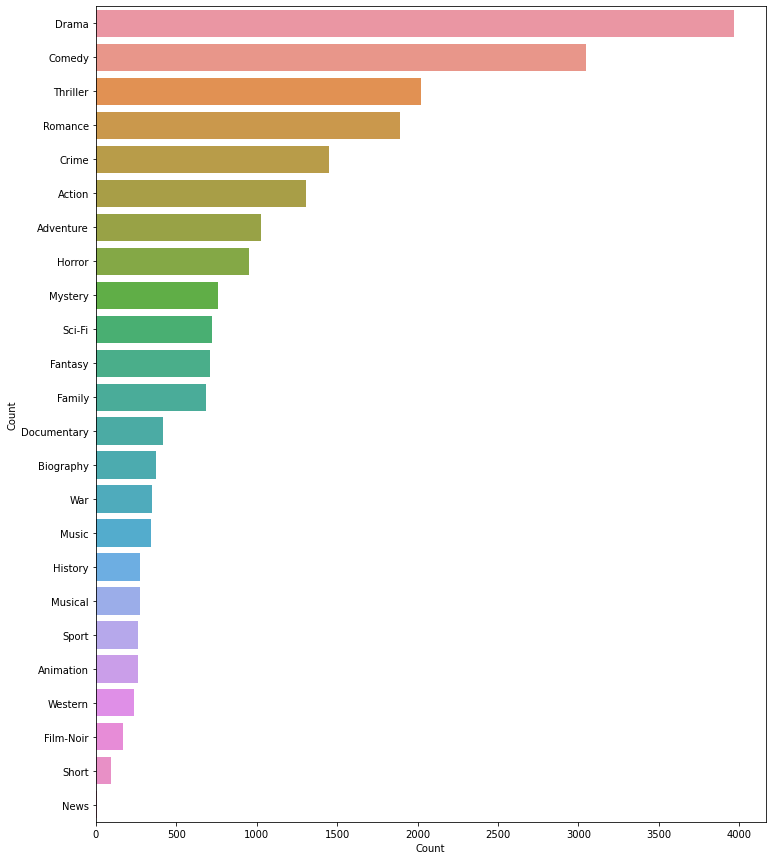

In [ ]:
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

La mayor proporción de géneros se encuentra concentrada en Drama, Comedia, Thriller y Romance. Cabe recordar, que la suma de las frecuencias no será el total de películas, ya que una película puede tener más de un género.

## Limpieza de datos

En primer lugar se quitarán carácteres especiales, contracciones más comunes, carácteres extraños y se pasarán todas las palabras a minúscula.


In [ ]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    text = re.sub(" n ", " ", text) 
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

dataTraining['clean_plot'] = dataTraining['plot'].apply(lambda x: clean_text(x))
dataTraining['clean_title'] = dataTraining['title'].apply(lambda x: clean_text(x))

dataTesting['clean_plot'] = dataTesting['plot'].apply(lambda x: clean_text(x))
dataTesting['clean_title'] = dataTesting['title'].apply(lambda x: clean_text(x))

In [ ]:
dataTraining['clean_plot']

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden a female blackmailer with a disfigur...
4704    in a friday afternoon in new york the presiden...
2582    in los angeles the editor of a publishing hous...
                              ...                        
8417    our marriage their wedding it s lesson number ...
1592    the wandering barbarian conan alongside his go...
1723    like a tale spun by scheherazade kismet follow...
7605    mrs brisby a widowed mouse lives in a cinder b...
215     tinker bell journey far north of never land to...
Name: clean_plot, Length: 7895, dtype: object

In [ ]:
char=[',','?','.','"','-','(',')','\'',' n ']
for i in range(0,len(char)):
  dataTraining['clean_plot']=dataTraining['clean_plot'].apply(lambda x: x.replace(char[i],''))
  dataTraining['clean_title']=dataTraining['clean_title'].apply(lambda x: x.replace(char[i],''))
  dataTesting['clean_plot']=dataTesting['clean_plot'].apply(lambda x: x.replace(char[i],''))
  dataTesting['clean_title']=dataTesting['clean_title'].apply(lambda x: x.replace(char[i],''))

<Figure size 1440x1440 with 0 Axes>

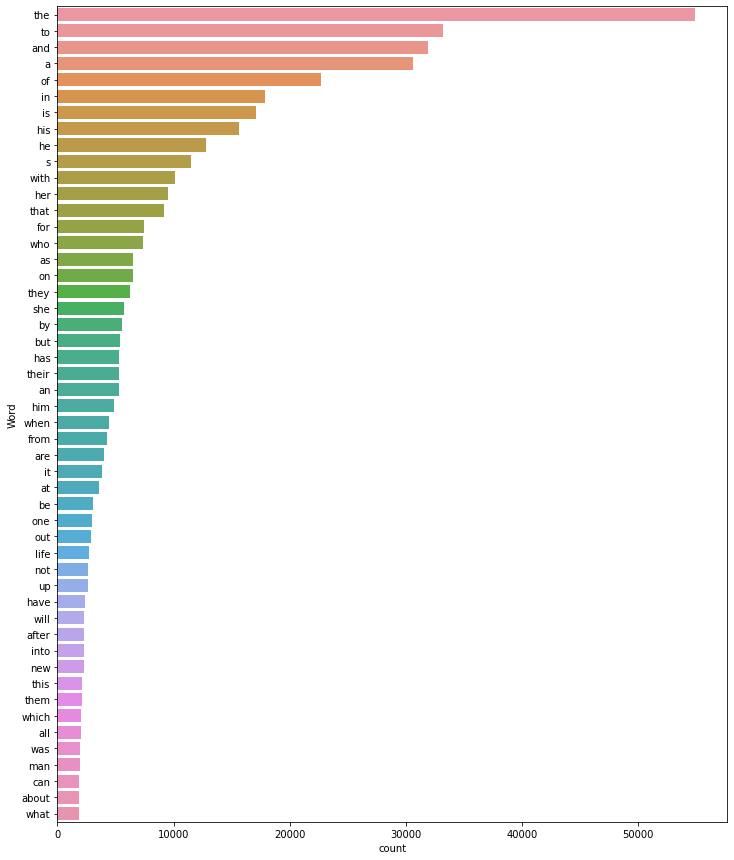

In [ ]:
plt.figure(figsize=(20,20)) 
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(dataTraining['clean_plot'], 50)

  

Las palabras con mayor frecuencia en el texto hacen referencia a conectores, auxiliares, preposiciones y en general, stopwords, que seguramente harán ruido en la estimación de los modelos. Para ello se removerán, así como una lematización y paso a forma raíz de las palabras.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
dataTraining['clean_plot'] = dataTraining['clean_plot'].apply(lambda x: remove_stopwords(x))
dataTraining['clean_title'] = dataTraining['clean_title'].apply(lambda x: remove_stopwords(x))
dataTesting['clean_plot'] = dataTesting['clean_plot'].apply(lambda x: remove_stopwords(x))
dataTesting['clean_title'] = dataTesting['clean_title'].apply(lambda x: remove_stopwords(x))

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


In [ ]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

ar=[]
for i in range(dataTraining.shape[0]):
    sentence = dataTraining.clean_plot.iloc[i]
    word_list = nltk.word_tokenize(sentence)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    ar.append(lemmatized_output)
st=[]
for i in range(len(ar)):
    sentence = ar[i]
    word_list = nltk.word_tokenize(sentence)
    stem_output = ' '.join([ps.stem(w) for w in word_list])
    st.append(stem_output)

In [ ]:
dataTraining['clean_plot_2']=st

In [ ]:
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

ar=[]
for i in range(dataTesting.shape[0]):
    sentence = dataTesting.clean_plot.iloc[i]
    word_list = nltk.word_tokenize(sentence)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    ar.append(lemmatized_output)
st=[]
for i in range(len(ar)):
    sentence = ar[i]
    word_list = nltk.word_tokenize(sentence)
    stem_output = ' '.join([ps.stem(w) for w in word_list])
    st.append(stem_output)

In [ ]:
dataTesting['clean_plot_2']=st

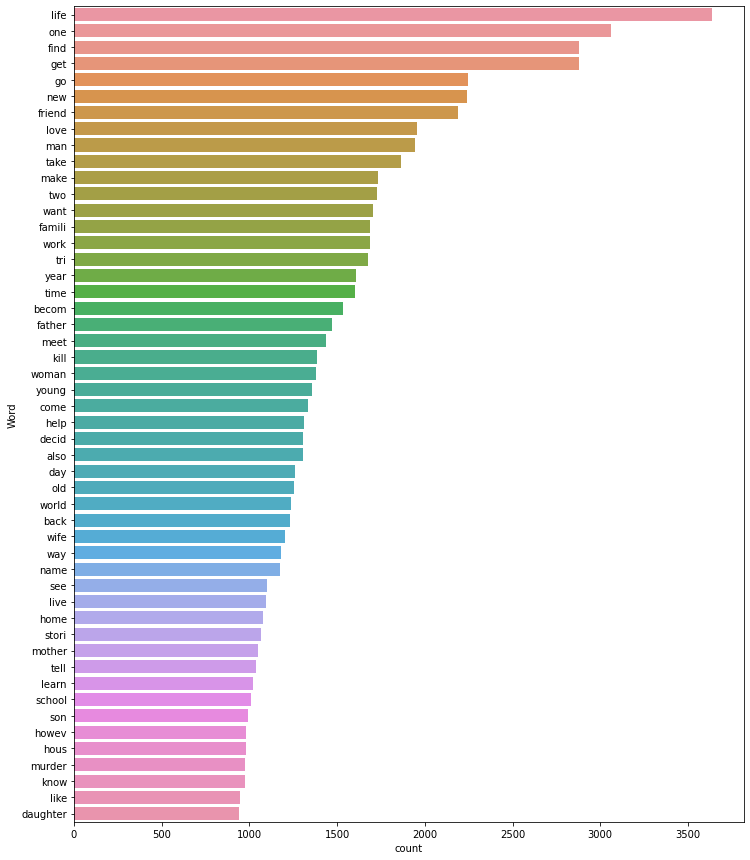

In [ ]:
freq_words(dataTraining['clean_plot_2'], 50)

En la gráfica descriptiva del texto procesado nos encontramos con las palabras más frecuentes en las descriptivas de las descripciones son life, one y find. Palabras bastantes comunes.

# Modelos propuestos
## Regresión Logística sobre TfidVectorizer

El primer modelo propuesto es una regresión logística sobre una transformación por pesos de las descripciones.

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(dataTraining['clean_plot_2'], y_genres, test_size=0.2, random_state=9)

In [ ]:
# create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [ ]:
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [ ]:
# make predictions for validation set
y_pred = clf.predict_proba(xval_tfidf)

In [ ]:
roc_auc_score(yval, y_pred, average='macro')

0.8817231334613632

Con este modelo se pudo dar cuenta la necesidad de probar diferentes metodologías Multi-label y la optimización de los parámetros en la transformación del texto a un espacio numérico; para ello se realizaron las siguientes pruebas:

## Regresión logística con Classifierchain

Mientras la estrategia One Vs Rest classifier ajusta un modelo para cada una de los géneros, esta estrategia de ClassifierChain ajusta un modelo en cadena para cada categoría $j$ que está asociada con las $j-1$ categorías anteriores.

In [ ]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [ ]:
classifier = ClassifierChain(LogisticRegression())

In [ ]:
classifier.fit(xtrain_tfidf, ytrain)

ClassifierChain(classifier=LogisticRegression(C=1.0, class_weight=None,
                                              dual=False, fit_intercept=True,
                                              intercept_scaling=1,
                                              l1_ratio=None, max_iter=100,
                                              multi_class='auto', n_jobs=None,
                                              penalty='l2', random_state=None,
                                              solver='lbfgs', tol=0.0001,
                                              verbose=0, warm_start=False),
                order=None, require_dense=[True, True])

In [ ]:
y_pred2 = clf.predict_proba(xval_tfidf)

In [ ]:
roc_auc_score(yval, y_pred2, average='macro')

0.8808571268761858

## Regresión logística con LabelPowerSet

Esta estrategia de transofrmación de la variables respuesta, evalúa cada una de las posibles $2^L$ combinaciones, en nuestro caso $L=24$, transformando el problema Multi-label a un problema Single label; y para cada una de las combinaciones ajusta un modelo.

In [ ]:
classifier = LabelPowerset(LogisticRegression())

In [ ]:
classifier.fit(xtrain_tfidf, ytrain)

LabelPowerset(classifier=LogisticRegression(C=1.0, class_weight=None,
                                            dual=False, fit_intercept=True,
                                            intercept_scaling=1, l1_ratio=None,
                                            max_iter=100, multi_class='auto',
                                            n_jobs=None, penalty='l2',
                                            random_state=None, solver='lbfgs',
                                            tol=0.0001, verbose=0,
                                            warm_start=False),
              require_dense=[True, True])

In [ ]:
y_pred3 = classifier.predict_proba(xval_tfidf)

In [ ]:
pd.DataFrame(y_pred3.todense())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.143145,0.118169,0.030443,0.042275,0.427740,0.157879,0.053132,0.503085,0.077771,0.077910,0.019304,0.031012,0.102296,0.040640,0.031462,0.084313,0.000864,0.300015,0.080677,0.009590,0.030850,0.225826,0.039064,0.025681
1,0.136890,0.114190,0.029595,0.041830,0.377105,0.157514,0.042854,0.584321,0.076748,0.076598,0.018113,0.030624,0.098473,0.038468,0.030329,0.082962,0.000833,0.292763,0.075704,0.009508,0.029767,0.218206,0.039714,0.025673
2,0.199591,0.149174,0.037561,0.051993,0.367408,0.213866,0.048009,0.477457,0.095882,0.096099,0.024140,0.037957,0.129314,0.048377,0.040365,0.108424,0.001043,0.210957,0.103151,0.011599,0.036827,0.296613,0.049386,0.030652
3,0.190136,0.148928,0.037297,0.050823,0.352213,0.205445,0.054793,0.467511,0.095380,0.096997,0.023766,0.038026,0.144337,0.046861,0.037780,0.110806,0.001047,0.198653,0.103418,0.011705,0.039646,0.298278,0.049662,0.032982
4,0.171328,0.143090,0.036289,0.051272,0.377438,0.179120,0.044425,0.522375,0.091812,0.094358,0.022718,0.036754,0.131230,0.045080,0.036408,0.097728,0.000993,0.253841,0.103250,0.011073,0.034916,0.262062,0.046035,0.029843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,0.154906,0.125664,0.032271,0.043909,0.402131,0.171273,0.045323,0.529778,0.082506,0.082529,0.020077,0.032476,0.108125,0.041433,0.033055,0.089135,0.000893,0.301276,0.084718,0.010161,0.031703,0.242011,0.041260,0.027541
1575,0.169149,0.140148,0.036770,0.050809,0.389932,0.181179,0.049839,0.484648,0.091699,0.093399,0.021849,0.036630,0.130641,0.047229,0.036937,0.095901,0.000989,0.214448,0.094431,0.011146,0.036153,0.258893,0.045703,0.032170
1576,0.186654,0.149121,0.039007,0.052406,0.367442,0.195414,0.052743,0.479174,0.098211,0.101497,0.023446,0.039231,0.137354,0.048329,0.038788,0.103071,0.001045,0.207217,0.098634,0.011661,0.036513,0.284361,0.048904,0.031356
1577,0.193633,0.141322,0.035183,0.047792,0.369005,0.221904,0.045344,0.477505,0.090393,0.092092,0.024372,0.035714,0.126228,0.045307,0.035124,0.103218,0.000991,0.229600,0.099482,0.011120,0.034878,0.294784,0.045611,0.031126


In [ ]:
roc_auc_score(yval, pd.DataFrame(y_pred3.todense()), average='macro')

0.7845490063299092

# Bidirectional Gated Recurrent Neural Network

En el presente trabajo se probaron diferentes modelos de redes neuronales como:

    1) Red neuronal simple con TfidVectorizer sobre el texto
    2) LSTM Red Neuronal con Embedding de Count Vectorizer
    3) CNN con TfidVectorizer
    4) LSTM y CNN model 
    5) Bidirectional Gated Recurrent Neural Network
    6) Bidirectional Gated Recurrent Neural and Convolutional Network

Siendo esta última, la que mejores resultados presentó. La idea de usar una red bidireccional es que la red aprendiera tanto de las palabras anteriores como de las siguientes para la clasificación en el género de la película. Además ultilizar GRU como estrategía de aprendizaje, tiene su explicación en que esta metodología es muy similar a LSTM, pero adopta un mecanismo de activación para rastrear el estado de la secuencia en lugar de usar una unidad de almacenamiento separada, lo que simplifica la estructura. Además aplicar una convolución en la semantica del texto previamente, sintetiza la relación de algunas palabras sobre la elección de los géneros.

Adicionalmente, para el embedding de los datos, se usaron unos pesos pre-entrenados de las palabras por un grupo de investigación de Stanford que se encuentran disponibles en su sitio Web http://nlp.stanford.edu/

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataTraining['clean_plot'])

train_sequences = tokenizer.texts_to_sequences(dataTraining['clean_plot'])
train_data = pad_sequences(train_sequences, maxlen=200)

In [ ]:
train_data

array([[    0,     0,     0, ...,  3712,  6475,    67],
       [    0,     0,     0, ...,  1098,   488,  1621],
       [    0,     0,     0, ...,     7,    30,  1753],
       ...,
       [    0,     0,     0, ...,   616,    11,   191],
       [    0,     0,     0, ...,    22, 16797,   106],
       [    0,     0,     0, ..., 12811,  3478,  1463]], dtype=int32)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-07-19 19:18:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-07-19 19:18:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-07-19 19:18:47--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
EMBEDDING_FILE = 'glove.6B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

In [ ]:
embedding_matrix = np.zeros((50000, 300))
for word, index in tokenizer.word_index.items():
    if index > 50000 - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataTraining['clean_plot_2'])

train_sequences = tokenizer.texts_to_sequences(dataTraining['clean_plot_2'])
train_data = pad_sequences(train_sequences, maxlen=200)

x_train, x_test, y_train, yval = train_test_split(train_data, y_genres, test_size=0.2, random_state=9)


In [ ]:
sequence_input = Input(shape=(max_len, ))
model = Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False)(sequence_input)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(model)
model = Conv1D(128, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(model)
avg_pool = GlobalAveragePooling1D()(model)
max_pool = GlobalMaxPooling1D()(model)
model = concatenate([avg_pool, max_pool]) 
#dense_1 = Dense(128, activation='relu')(model)
preds = Dense(24, activation="sigmoid")(model)
Bil_GRU_Glove_model = Model(sequence_input, preds)
Bil_GRU_Glove_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC()])

In [ ]:
Bil_GRU_Glove_model_fit = Bil_GRU_Glove_model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, yval), callbacks=[early])

Train on 6316 samples, validate on 1579 samples
Epoch 1/50
6316/6316 [==============================] - 123s 20ms/step - loss: 0.3268 - auc_17: 0.6849 - val_loss: 0.2702 - val_auc_17: 0.7602
Epoch 2/50
6316/6316 [==============================] - 122s 19ms/step - loss: 0.2577 - auc_17: 0.7898 - val_loss: 0.2447 - val_auc_17: 0.8120
Epoch 3/50
6316/6316 [==============================] - 121s 19ms/step - loss: 0.2600 - auc_17: 0.8277 - val_loss: 0.2346 - val_auc_17: 0.8398
Epoch 4/50
6316/6316 [==============================] - 121s 19ms/step - loss: 0.2239 - auc_17: 0.8492 - val_loss: 0.2265 - val_auc_17: 0.8566
Epoch 5/50
6316/6316 [==============================] - 122s 19ms/step - loss: 0.2146 - auc_17: 0.8632 - val_loss: 0.2215 - val_auc_17: 0.8685
Epoch 6/50
6316/6316 [==============================] - 123s 19ms/step - loss: 0.2079 - auc_17: 0.8732 - val_loss: 0.2183 - val_auc_17: 0.8773
Epoch 7/50
6316/6316 [==============================] - 122s 19ms/step - loss: 0.2016 - auc_17

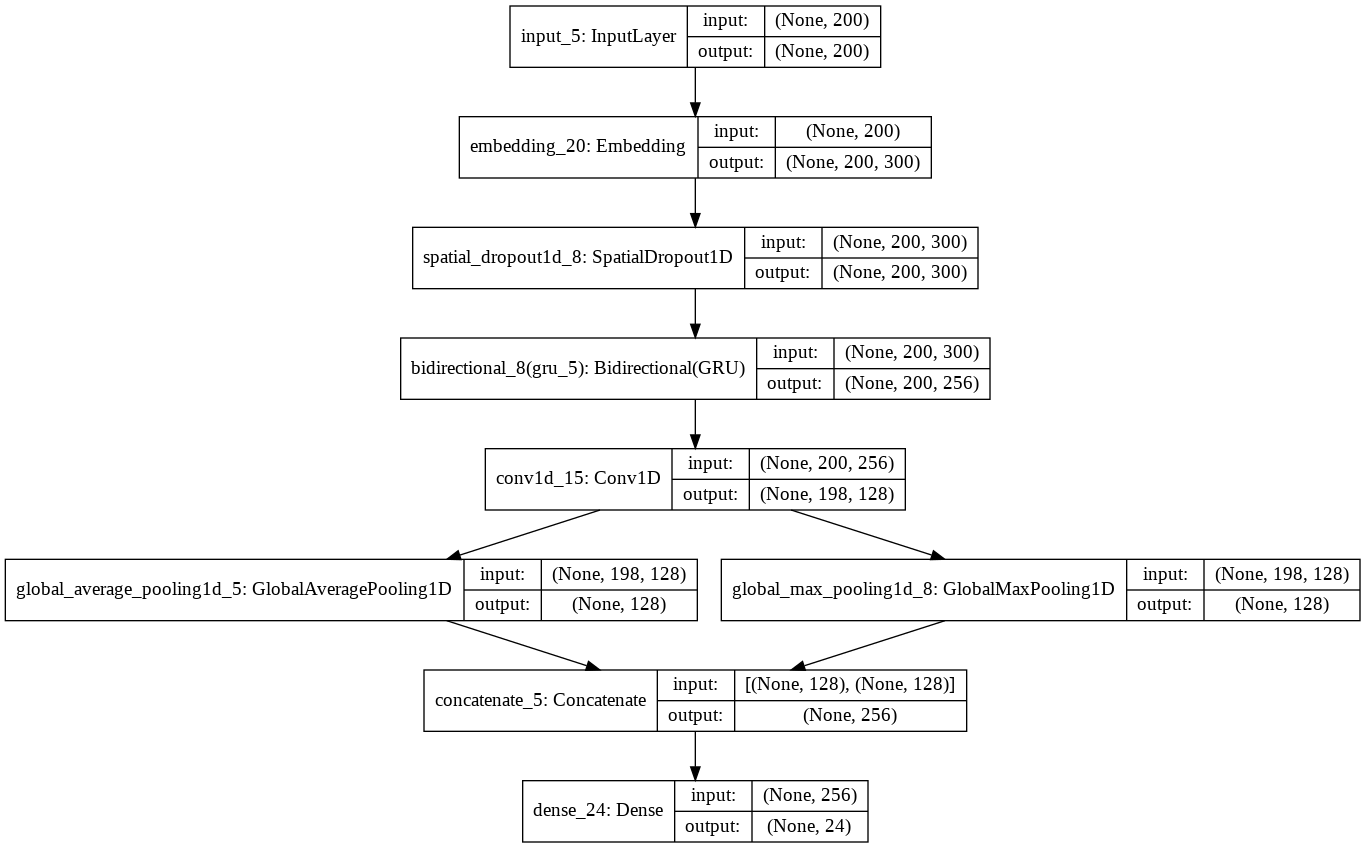

In [ ]:
#plot the GRU model architecture
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(Bil_GRU_Glove_model, to_file='/content/gdrive/My Drive/Bil_GRU_Glove_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='/content/gdrive/My Drive/Bil_GRU_Glove_model_plot.png') 

In [ ]:
 prediccion_3 = Bil_GRU_Glove_model_fit.model.predict(x_test)
 roc_auc_score(yval, prediccion_3, average='macro')

0.8684155695273613

Sin embargo, este modelo en la parte de validación no mostró mejores resultados que los modelos probados anteriormente. Por ello, se vió en la necesidad de entrenar un modelo con mayor coste computacional.

## Regresión Logistica con optimización de parámetros

Se decide entonces, entrenar un modelo SVM optimizando los parámetros de la siguiente manera:

### Optimización TFIDF FASE 1



Despues de hacer la limpieza a los textos, eliminar stop_words, caracteres especiales, y lematizar las palabras, realizamos una optimización del TF-IDF sobre los parémtros max_df (Cota superior de pesos considerados en el TF-IDF), min_df (Cota inferior de pesos considerados en el TF-IDF), max_feature (longitud máxima de tokens considerados en la matriz de pesos)y ngram_range(combinando de tokens, unigramas, bigramas,etc). 

In [ ]:
maxdf=[0.5,0.7,0.75,0.8,0.85,0.9,1.0]
mindf=[0.0,0.002,0.005,0.01,0.02]
maxfeat=[5000,7000,10000,15000,20000,30000,40000]


for i in range(0,len(maxdf)):
  for j in range(0,len(maxfeat)):
    for k in range(0,len(mindf)): 
      lr = LogisticRegression()
      clog = OneVsRestClassifier(lr)
      tfvect= TfidfVectorizer(max_df=maxdf[i], max_features=maxfeat[j],min_df=mindf[k])   
      Xtf=pd.DataFrame(tfvect.fit_transform(dataTraining2['clean_plot']).toarray(), columns=tfvect.get_feature_names())
      X_fin=Xtf.iloc[0:7895]
      xtrain, xval, ytrain, yval = train_test_split(X_fin, y, test_size=0.2, random_state=9)
      clog.fit(xtrain, ytrain)
      y_pred = clog.predict_proba(xval)
      auc=roc_auc_score(yval, y_pred, average='macro')
      #print("auc",auc,"maxdf",maxdf[i],"max_feat",maxfeat[j])
      print("auc",auc,"maxdf",maxdf[i],"max_feat",maxfeat[j],"mindf",mindf[k])


auc 0.876996740465192 maxdf 0.5 max_feat 5000 mindf 0.0
auc 0.875392491651673 maxdf 0.5 max_feat 5000 mindf 0.002
auc 0.8505262115065628 maxdf 0.5 max_feat 5000 mindf 0.005
auc 0.8323733827297989 maxdf 0.5 max_feat 5000 mindf 0.01
auc 0.7997850452205214 maxdf 0.5 max_feat 5000 mindf 0.02
auc 0.8793273908889355 maxdf 0.5 max_feat 7000 mindf 0.0
auc 0.875392491651673 maxdf 0.5 max_feat 7000 mindf 0.002
auc 0.8505262115065628 maxdf 0.5 max_feat 7000 mindf 0.005
auc 0.8323733827297989 maxdf 0.5 max_feat 7000 mindf 0.01
auc 0.7997850452205214 maxdf 0.5 max_feat 7000 mindf 0.02
auc 0.8803027595237426 maxdf 0.5 max_feat 10000 mindf 0.0
auc 0.875392491651673 maxdf 0.5 max_feat 10000 mindf 0.002
auc 0.8505262115065628 maxdf 0.5 max_feat 10000 mindf 0.005
auc 0.8323733827297989 maxdf 0.5 max_feat 10000 mindf 0.01
auc 0.7997850452205214 maxdf 0.5 max_feat 10000 mindf 0.02
auc 0.8813733426409428 maxdf 0.5 max_feat 15000 mindf 0.0
auc 0.875392491651673 maxdf 0.5 max_feat 15000 mindf 0.002
auc 0.850

KeyboardInterrupt: ignored

### Optimización TFIDF FASE 2

Ahora acotamos un poco los límites de los parámetros e incluimos ngramas hasta combinaciones de 2 palabras

In [ ]:

maxdf=[0.5,0.55,0.6,0.65,0.68]
mindf=[0.0,0.00001,0.0001,0.001]
maxfeat=[30000,35000,40000,42000,45000,47000]
maxngram=[1,2]

for i in range(0,len(maxdf)):
  for j in range(0,len(maxfeat)):
    for k in range(0,len(mindf)):
      for l in range(0,len(maxngram)): 
        lr = LogisticRegression()
        clog = OneVsRestClassifier(lr)
        tfvect= TfidfVectorizer(max_df=maxdf[i], max_features=maxfeat[j],min_df=mindf[k],ngram_range=(maxngram[l],2))   
        Xtf=pd.DataFrame(tfvect.fit_transform(dataTraining2['clean_plot']).toarray(), columns=tfvect.get_feature_names())
        X_fin=Xtf.iloc[0:7895]
        xtrain, xval, ytrain, yval = train_test_split(X_fin, y, test_size=0.2, random_state=9)
        clog.fit(xtrain, ytrain)
        y_pred = clog.predict_proba(xval)
        auc=roc_auc_score(yval, y_pred, average='macro')
        #auc_par=print("auc",auc,"maxdf",maxdf[i],"max_feat",maxfeat[j],"mindf",mindf[k])
        #auc_vec.append(auc_par)
        print("auc",auc,"maxdf",maxdf[i],"max_feat",maxfeat[j],"mindf",mindf[k],"max_ngram",maxngram[l],2)

auc 0.8844401815034653 maxdf 0.5 max_feat 40000 mindf 0.0 max_ngram 1 2


Despues de realizar la optimización del TF-IDF, e ir acotando los límites de cada parámetro los mejores parámetros son max_df= 0.5 (Cota superior de pesos considerados en el TF-IDF), min_df=0.0 (Cota inferior de pesos considerados en el TF-IDF), max_feature=40000 (longitud máxima de tokens considerados en la matriz de pesos)y ngram_range= (1,2), es decir combinando unigramas y bigramas. 

## SVM Con optimización de parámetros

In [ ]:
pipe3=Pipeline([('TFidf',TfidfVectorizer()),('SVC', OneVsRestClassifier(SVC(probability=True,kernel="rbf")))])

In [ ]:
parameters = {
                'TFidf__max_df': (0.25, 0.5, 0.75),
                'TFidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                "SVC__estimator__C": [0.01, 0.1, 1, 10, 100],
                #"SVC__estimator__class_weight": ['balanced', None]#,
                #"SVC__kernel":['rbf']
            }

grid_search_tune = GridSearchCV(pipe3, parameters, cv=2, n_jobs=-1, verbose=10)
grid_search_tune.fit(X_train_1['clean_plot'], y_train_genres_1)

grid_search(X_train_1['clean_plot'], y_train_genres_1, X_test_1['clean_plot'], y_test_genres, genres, parameters, pipe3)

'\nparameters = {\n                \'TFidf__max_df\': (0.25, 0.5, 0.75),\n                \'TFidf__ngram_range\': [(1, 1), (1, 2), (1, 3)],\n                "SVC__estimator__C": [0.01, 0.1, 1, 10, 100],\n                #"SVC__estimator__class_weight": [\'balanced\', None]#,\n                #"SVC__kernel":[\'rbf\']\n            }\n\ngrid_search_tune = GridSearchCV(pipe3, parameters, cv=2, n_jobs=-1, verbose=10)\ngrid_search_tune.fit(X_train_1[\'clean_plot\'], y_train_genres_1)\n'

Finalmente la mejor combinación de parámetros para este modelo fue max_df=0.25, n_gram=(1,1), kernel='rbf' y C=1

In [ ]:
pipe3=Pipeline([('TFidf',TfidfVectorizer(max_df=0.25,ngram_range=(1, 1))),('SVC', OneVsRestClassifier(SVC(probability=True,class_weight='balanced',C=1,kernel='rbf')))])

In [ ]:
pipe3.fit(X_train_1['clean_plot'],y_train_genres_1)

Pipeline(memory=None,
         steps=[('TFidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.25, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern=...\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('SVC',
                 OneVsRestClassifier(estimator=SVC(C=1, break_ties=False,
                                                   cache_size=200,
           

In [ ]:
predicted3=pipe3.predict_proba(X_test_1['clean_plot'])
pd.DataFrame(predicted3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0.024910,0.027293,0.003362,0.018705,0.045530,0.364558,0.091274,0.761363,0.012135,0.051725,0.006862,0.023774,0.190074,0.014883,0.003068,0.033811,0.001473,0.065925,0.012934,0.006115,0.006476,0.372001,0.009084,0.011303
1,0.079060,0.359578,0.017375,0.088128,0.166376,0.013628,0.008642,0.610139,0.102901,0.030228,0.019396,0.183438,0.003627,0.002247,0.024070,0.075261,0.000566,0.221808,0.013059,0.008077,0.004889,0.100724,0.984006,0.000623
2,0.684066,0.262893,0.021227,0.018489,0.080691,0.074631,0.012922,0.137944,0.021427,0.035069,0.006653,0.012586,0.687017,0.009750,0.007915,0.100608,0.000808,0.020173,0.967897,0.004868,0.002410,0.467726,0.006540,0.002570
3,0.473443,0.146145,0.012652,0.022054,0.133267,0.291540,0.001903,0.454964,0.010909,0.020703,0.008525,0.029178,0.043947,0.017046,0.048586,0.079912,0.000574,0.058849,0.018985,0.003759,0.002406,0.321167,0.071033,0.339782
4,0.332001,0.293510,0.011129,0.037842,0.228121,0.048077,0.097127,0.252867,0.031005,0.563508,0.008017,0.065456,0.216072,0.021710,0.008861,0.019596,0.000582,0.042746,0.429404,0.017352,0.006533,0.116257,0.030785,0.000487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,0.010814,0.009154,0.003105,0.040450,0.722586,0.029443,0.002698,0.854117,0.015394,0.007424,0.013836,0.004212,0.008161,0.280075,0.032377,0.019544,0.000567,0.342215,0.003257,0.002558,0.007109,0.048889,0.004843,0.001174
2602,0.074561,0.195045,0.020588,0.065251,0.163623,0.016168,0.079126,0.535244,0.053492,0.124180,0.005738,0.014708,0.093575,0.033237,0.044060,0.016180,0.001116,0.133127,0.129658,0.010195,0.009587,0.091240,0.018802,0.002722
2603,0.017154,0.097457,0.150099,0.079016,0.309535,0.440285,0.004429,0.719839,0.543946,0.083525,0.006071,0.005594,0.020165,0.003518,0.005487,0.011966,0.001712,0.090875,0.014708,0.004257,0.005025,0.131182,0.000505,0.004963
2604,0.000924,0.026958,0.008015,0.032482,0.465515,0.045596,0.001578,0.911931,0.064737,0.025028,0.012352,0.003244,0.227222,0.014672,0.002057,0.288957,0.000431,0.311424,0.012280,0.004733,0.010996,0.275579,0.001087,0.000065


In [ ]:
roc_auc_score(y_test_genres, predicted3, average='macro')

0.8712507031106519

Finalmente, fue este modelo el que mejores resultados presentó sobre la muestra de Test de la competencia; sin embargo, es computacionalmente muy pesado para montar la API por ello se decide montar otro modelo con buen desempeño.

## Ramdon Forest Model (API)

Debido al peso del mejor modelo y como avanzamos en paralelo con el montado de la API, esta está ajustada con un modelo de Ramdonforest con 100 árboles (n_estimators=100) y una profundidad máxima de 10 (max_depth=10), igual manteniendo el OneVsRestClassifier para el Multilabel de la variables respuesta

In [ ]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))

In [ ]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

In [ ]:
y_pred_genres = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.7668587460707162

## Exportar base Testing para la competencia en kaggle

In [ ]:
X_test_dtm = vect.transform(dataTesting['clean_plot_2'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']


In [ ]:
y_pred_test_genres =pipe3.predict_proba(dataTesting['clean_plot'])

In [ ]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [ ]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,p_Film-Noir,p_History,p_Horror,p_Music,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.003999,0.002853,0.000188,0.000163,0.008126,0.004611,0.000196,0.332813,7.073591e-04,0.175499,0.000278,0.000039,0.000184,0.000407,0.001923,0.007652,0.000069,0.997460,0.000177,2.810908e-04,0.000188,0.045659,0.000140,0.000151
4,0.035387,0.000038,0.000396,0.048062,0.197765,0.352534,0.000366,0.966479,6.366224e-05,0.000062,0.000432,0.000063,0.003160,0.001340,0.000554,0.000114,0.000343,0.000145,0.000044,3.095654e-04,0.000482,0.172300,0.000693,0.000461
5,0.000093,0.000001,0.000002,0.000105,0.000057,0.974081,0.000007,0.999411,5.819659e-07,0.000001,0.000686,0.000008,0.000001,0.000008,0.000004,0.251879,0.000003,0.000097,0.000250,1.898161e-06,0.000010,0.818085,0.000020,0.000008
6,0.000133,0.000270,0.000001,0.000014,0.000221,0.000045,0.000010,0.999724,2.591796e-05,0.000006,0.000099,0.000514,0.000622,0.000003,0.000065,0.000042,0.000002,0.036963,0.001417,8.457588e-07,0.000009,0.808904,0.001885,0.000006
7,0.000018,0.000032,0.000077,0.000030,0.001509,0.000518,0.000088,0.224521,3.961555e-04,0.020471,0.006144,0.000008,0.684891,0.000011,0.000040,0.004089,0.000052,0.010581,0.268359,4.581997e-05,0.000016,0.418338,0.000033,0.000080


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
res.to_csv('/content/gdrive/My Drive/pred_genres_text_RF.csv', index_label='ID')

# API Modelo Optimizado

Como se comentó anteriormente, si bien el modelo que mejor desempeño tuvo fue el SVM optimizado; sin embargo este presenta un altisimo costo computacional para lo cual se vió en la necesidad de montar en la API el modelo de RandomForest mencionado arriba.



# URL API
**URL:** http://ec2-3-128-176-1.us-east-2.compute.amazonaws.com:5000/